# Solution

## Initialization

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
env = UnityEnvironment(file_name='./Tennis_Linux_NoVis/Tennis.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
state_size = env_info.vector_observations.shape[1]

## MADDPG

In [5]:
import random
import torch
from collections import deque
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from maddpg.maddpg_agents import Group

In [7]:
group = Group(num_agents=num_agents, state_size=state_size, action_size=action_size, random_seed=2)

In [8]:
def run_maddpg(n_episodes=1000, print_every=100):
    solved = False
    target_score = 0.5
    scores_deque = deque(maxlen=print_every)
    scores = []
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        ## group.reset() # !!
        episode_scores = np.zeros(num_agents)

        while True:
            group.reset_noise() # !!
            actions = group.act(states) # !!
            
            
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            group.step(states, actions, rewards, next_states, dones) # !!
            
            states = next_states
            episode_scores += np.array(rewards)
            if np.any(dones):
                break 
        
        score = episode_scores.max()
        scores_deque.append(score)
        scores.append(score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(group.checkpoint(), 'checkpoints/checkpoint_group.pth')
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if np.mean(scores_deque)>=target_score and not solved:
            solved = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            timestamp = dt.now().strftime("%Y-%m-%d_%H:%M:%S")
            torch.save(group.checkpoint(), f'checkpoints/checkpoint_group_{timestamp}.pth')
            
    return scores

In [9]:
%%time
scores = run_maddpg(n_episodes=10000)

Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.01
Episode 300	Average Score: 0.00
Episode 400	Average Score: 0.00
Episode 500	Average Score: 0.00
Episode 600	Average Score: 0.00
Episode 700	Average Score: 0.00
Episode 800	Average Score: 0.04
Episode 900	Average Score: 0.06
Episode 1000	Average Score: 0.08
Episode 1100	Average Score: 0.10
Episode 1200	Average Score: 0.15
Episode 1300	Average Score: 0.22
Episode 1400	Average Score: 0.22
Episode 1500	Average Score: 0.19
Episode 1600	Average Score: 0.22
Episode 1700	Average Score: 0.21
Episode 1800	Average Score: 0.14
Episode 1900	Average Score: 0.11
Episode 2000	Average Score: 0.14
Episode 2100	Average Score: 0.14
Episode 2200	Average Score: 0.19
Episode 2300	Average Score: 0.17
Episode 2400	Average Score: 0.14
Episode 2500	Average Score: 0.13
Episode 2600	Average Score: 0.15
Episode 2700	Average Score: 0.15
Episode 2800	Average Score: 0.19
Episode 2860	Average Score: 0.51
Environment solved in 2860 episodes!	Average Score: 

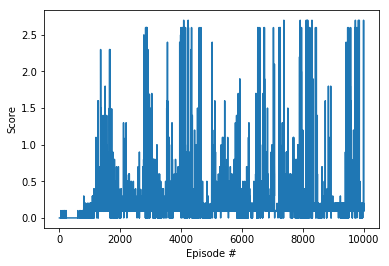

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()